In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset("/Users/pablo/ERA5/precip_201701_d.nc")
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 768)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 ...
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 89.0 88.75 88.5 ...
  * time       (time) datetime64[ns] 2017-01-01T06:00:00 2017-01-01T07:00:00 ...
Data variables:
    tp         (time, latitude, longitude) float32 ...
    ptype      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2018-06-30 02:42:13 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

-3.725290298461914e-09
0.031094413250684738


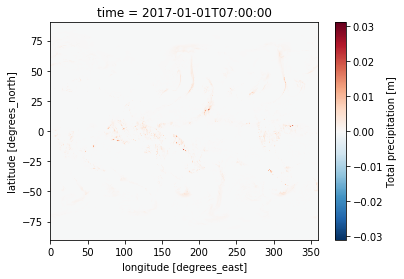

In [28]:
print(ds["tp"][1,:].min().data)
print(ds["tp"][1,:].max().data)

ds["tp"][1,:].plot()

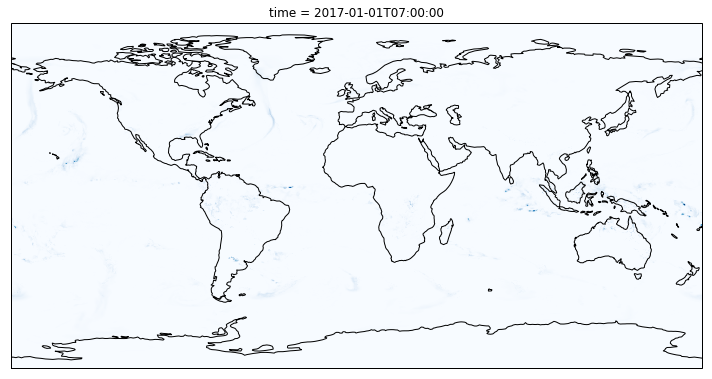

In [29]:
import cartopy.crs as ccrs

plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.PlateCarree())

ds["tp"][1,:].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.03,
                              x='longitude', y='latitude', add_colorbar=False, cmap=plt.cm.Blues)


ax.coastlines()

plt.tight_layout()

In [3]:
%matplotlib inline

import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

def get_filepaths(start, accum_hours):
    pattern = "/g/data/fj4/SatellitePrecip/GPM/global/final/{ym}/3B-HHR.MS.MRG.3IMERG.{ymd}-S{sHMS}-E{eHMS}.{mins_day:04d}.V05B.HDF5"
    accum = np.zeros((1800, 3600), dtype=np.float32)
    
    for i in range(2*accum_hours):
        file_path = pattern.format(ym=start.strftime('%Y%m'), ymd=start.strftime('%Y%m%d'), sHMS=start.strftime('%H%M%S'), eHMS=(start+timedelta(minutes=29, seconds=59)).strftime('%H%M%S'), mins_day=start.hour*60+start.minute)
        with h5py.File(file_path, mode='r') as f:
            arr = f['Grid']['precipitationUncal'][:].T
            arr[arr==-9999.9] = np.nan
            accum = accum + arr

    return accum/2
        
start = datetime(2016, 11, 22, 12, 30, 0)
accum = get_filepaths(start, 3)
plt.imsave("test.png", accum)

OSError: Unable to open file (unable to open file: name = '/g/data/fj4/SatellitePrecip/GPM/global/final/201611/3B-HHR.MS.MRG.3IMERG.20161122-S123000-E125959.0750.V05B.HDF5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [49]:
import netCDF4
import h5py
import numpy as np
from datetime import datetime
from datetime import timedelta

def get_gpm_filepaths(start, accum_steps):
    pattern = "/g/data/fj4/SatellitePrecip/GPM/global/final/{ym}/3B-HHR.MS.MRG.3IMERG.{ymd}-S{sHMS}-E{eHMS}.{mins_day:04d}.V05B.HDF5"
    
    paths = []
    for _ in range(accum_steps):
        paths.append(pattern.format(ym=start.strftime('%Y%m'), ymd=start.strftime('%Y%m%d'), sHMS=start.strftime('%H%M%S'), eHMS=(start+timedelta(minutes=29, seconds=59)).strftime('%H%M%S'), mins_day=start.hour*60+start.minute))
        start = start + timedelta(minutes=30)

    return paths
  

with netCDF4.Dataset("/Users/pablo/GPM/prec_201601.nc", 'w', format='NETCDF4') as dest:
    
    prec_arr = np.zeros((8, 1800, 3600), dtype=np.float32)
    
    
    start = datetime(2016, 1, 1)
    end = datetime(2016, 2, 1)

    timestamps = []

    i = 0
    while start < end:
        timestamps.append(start)
        
        prec_accum = np.zeros((1800, 3600), dtype=np.float32)
        for filepath in get_gpm_filepaths(start, 6):
            with h5py.File(filepath, mode='r') as f:
                prec = f['Grid']['precipitationCal'][:].T
                prec[prec==-9999.9] = np.nan
                prec_accum = prec_accum + prec
                
        prec_arr[i, :, :] = prec_accum / 3

        start += timedelta(hours=3)
        i += 1
            
    setattr(dest, "date_created", datetime.now().strftime("%Y%m%dT%H%M%S"))
    setattr(dest, "Conventions", "CF-1.6")

    x_dim = dest.createDimension("longitude", prec_arr.shape[2])
    y_dim = dest.createDimension("latitude", prec_arr.shape[1])
    t_dim = dest.createDimension("time", prec_arr.shape[0])
    
    timestamps = []
    for i in range(8):
        start = datetime(2016, 1, 1)
        timestamps.append(start + timedelta(hours=3*i))
        
    print(timestamps)

    var = dest.createVariable("time", "f8", ("time",))
    var.units = "seconds since 1970-01-01 00:00:00.0"
    var.calendar = "standard"
    var.long_name = "Time, unix time-stamp"
    var.standard_name = "time"
    var[:] = netCDF4.date2num(timestamps, units="seconds since 1970-01-01 00:00:00.0", calendar="standard")
        
    var = dest.createVariable("longitude", "f8", ("longitude",))
    var.units = "degrees_east"
    var.long_name = "longitude"
    var[:] = np.linspace(-179.95, 179.95, 3600)

    var = dest.createVariable("latitude", "f8", ("latitude",))
    var.units = "degrees_north"
    var.long_name = "latitude"
    var[:] = np.linspace(-89.95, 89.95, 1800)

    var = dest.createVariable("precipitationCal", "f4", ("time", "latitude", "longitude"), fill_value=-9999.9, zlib=True, chunksizes=(8, 400, 400))
    var.long_name = "Precipitation Calibrated"
    var.units = 'mm'
    var[:] = prec_arr


OSError: Unable to open file (unable to open file: name = '/g/data/fj4/SatellitePrecip/GPM/global/final/201601/3B-HHR.MS.MRG.3IMERG.20160101-S000000-E002959.0000.V05B.HDF5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [61]:
def get_gpm_filepaths(start, accum_steps):
    pattern = "/g/data/fj4/SatellitePrecip/GPM/global/final/{ym}/3B-HHR.MS.MRG.3IMERG.{ymd}-S{sHMS}-E{eHMS}.{mins_day:04d}.V05B.HDF5"
    
    paths = []
    for _ in range(accum_steps):
        paths.append(pattern.format(ym=start.strftime('%Y%m'), ymd=start.strftime('%Y%m%d'), sHMS=start.strftime('%H%M%S'), eHMS=(start+timedelta(minutes=29, seconds=59)).strftime('%H%M%S'), mins_day=start.hour*60+start.minute))
        start = start + timedelta(minutes=30)

    return paths


start = datetime(2016, 1, 1)
end = datetime(2016, 2, 1)
timestamps = []

for i=0; start < end; i++:
    timestamps.append(start)
    
    print(get_gpm_filepaths(start, 6))
    print(i)

    start += timedelta(hours=3)

print(timestamps)
print(len(timestamps))

SyntaxError: invalid syntax (<ipython-input-61-f4e7e7e22df1>, line 16)